# Cat Challenge + Encoding Guide + Basic Framework
### How can we encode different types of categorical features?

![GentleCat](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTSFF8K1-XmiGDkB7i_eIqxD_6ImLH4BXMsLMhZNAbiDeqR9oO0)

The aim of this notebook is to show the classical steps in a Machine Learning project that depends on a dataset characterized by many different types of categorical features. We will follow the conventional data science approach:

1. Data reading + Exploration / Transformation
2. Dimentionality Reduction
3. Model Selection + Validation
4. Stacking Individual Models
5. Conclusions

I will be direct and I will also try to show different techniques that can be applied here, without losing time or lines of code. Let's begin!

# 0. Importing the Libraries

Here we can take a look at all the libraries and resources that will be necessary to our project. It's interesting to aways start by this step to create a code with more quality and maintenability:

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

from category_encoders import TargetEncoder
from joblib import Parallel, delayed

from plotnine import *
from tqdm import *

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
       print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./test.csv
./.Rhistory
./sample_submission.csv
./df_cv.csv
./train.csv
./df_cv_complete.csv
./CAT Guide! Encoding Techniques + PCA + Gridsearch.ipynb
./df_out_logistic_model_A.csv
./df_out_logistic_model_B.csv
./.ipynb_checkpoints/CAT Guide! Encoding Techniques + PCA + Gridsearch-checkpoint.ipynb
./.ipynb_checkpoints/Untitled-checkpoint.ipynb
./.ipynb_checkpoints/cat_challenge-checkpoint.ipynb


# 1. Reading and Exploring / Transforming the Data

Finally, let's start by taking a look at what we have:

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6]
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 

# input_dir = '/kaggle/input/cat-in-the-dat-ii/'
input_dir = './'

In [3]:
df_train_raw = pd.read_csv(input_dir + 'train.csv')
df_test_raw = pd.read_csv(input_dir + 'test.csv')

df_train_raw.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


Transforming some binary features to zeros and ones:

In [4]:
df_train_raw_transformed = df_train_raw.\
    assign(bin_3 = df_train_raw['bin_3'].map(lambda X: 0 if (X == 'F') else\
                                             (1 if (X == 'T') else np.nan))).\
    assign(bin_4 = df_train_raw['bin_4'].map(lambda X: 0 if (X == 'N') else\
                                             (1 if (X == 'Y') else np.nan)))

df_train_raw_transformed.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,0.0,0.0,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,0.0,1.0,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,0.0,0.0,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,0.0,0.0,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,1.0,0.0,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [5]:
df_test_raw_transformed = df_test_raw.\
    assign(bin_3 = df_test_raw['bin_3'].map(lambda X: 0 if (X == 'F') else\
                                             (1 if (X == 'T') else np.nan))).\
    assign(bin_4 = df_test_raw['bin_4'].map(lambda X: 0 if (X == 'N') else\
                                             (1 if (X == 'Y') else np.nan)))

In [6]:
print("ORD_0:")
print(df_train_raw_transformed['ord_0'].unique())
print("---\nORD1:")
print(df_train_raw_transformed['ord_1'].unique())
print("---\nORD2:")
print(df_train_raw_transformed['ord_2'].unique())
print("---\nORD3:")
print(df_train_raw_transformed['ord_3'].unique())
print("---\nORD4:")
print(df_train_raw_transformed['ord_4'].unique())
print("---\nORD5:")
print(df_train_raw_transformed['ord_5'].unique())

ORD_0:
[ 3.  1.  2. nan]
---
ORD1:
['Contributor' 'Grandmaster' nan 'Novice' 'Expert' 'Master']
---
ORD2:
['Hot' 'Warm' 'Freezing' 'Lava Hot' 'Cold' 'Boiling Hot' nan]
---
ORD3:
['c' 'e' 'n' 'a' 'h' 'b' 'd' 'k' 'g' 'o' 'i' 'm' nan 'f' 'l' 'j']
---
ORD4:
['U' 'X' 'P' 'C' 'Q' 'R' 'Y' 'N' 'I' 'O' 'M' 'E' 'V' 'K' 'G' 'B' 'H' nan
 'T' 'W' 'A' 'F' 'D' 'S' 'J' 'L' 'Z']
---
ORD5:
['Pw' 'pE' 'eN' nan 'OZ' 'wa' 'rg' 'PS' 'mX' 'hG' 'xF' 'RV' 'Nh' 'dp' 'SS'
 'OM' 'Rv' 'HF' 'iS' 'HK' 'Ib' 'AW' 'mi' 'jf' 'Tz' 'ok' 'nS' 'Sz' 'sf'
 'Fl' 'fV' 'iv' 'US' 'dh' 'Io' 'RD' 'oI' 'DN' 'IS' 'oh' 'YJ' 'vq' 'us'
 'sY' 'th' 'Ey' 'AI' 'Mg' 'oU' 'Dj' 'TH' 'CN' 'aA' 'tT' 'Wr' 'TZ' 'mo'
 'rM' 'Pk' 'UV' 'RT' 'DT' 'Hk' 'Dn' 'nj' 'gL' 'cy' 'JT' 'XC' 'lA' 'TL'
 'zp' 'XM' 'AG' 'WW' 'GZ' 'MV' 'Bx' 'oJ' 'ze' 'Rj' 'LY' 'Iq' 'gc' 'LS'
 'hx' 'JQ' 'fO' 'vx' 'MX' 'ly' 'BX' 'Yr' 'XR' 'yE' 'Sk' 'aE' 'wU' 'rA'
 'Ji' 'qN' 'nn' 'kv' 'pB' 'sc' 'EC' 'kT' 'be' 'uQ' 'DI' 'hT' 'pl' 'tn'
 'xG' 'NT' 'fe' 'lS' 'Mq' 'Yi' 'BL' 'AU' 'ht' 'Ro' 'a

OK. We have not many columns in our problem. But we do have some columns with many different values, which can be a problem. Why? Well, when we transform string features to binary features we will create a number of dimentions equal to the number of different features less $1$ (we can subtract one because the case where all the columns are equal to zero corresponds to one of the strings). 

This kind of encoding is called "Binary Encoding" and when we get many dimentions thanks to the great number of different string values we get the problem known as the "curse of dimentionality" and the number of features with a given dummy column equal to one decreases exponentially:

![CurseOfDimentionality](https://www.elasticfeed.com/wp-content/uploads/3e5fca2cb938bbc9f5a1cae43bac0944.jpg)

That's why it's interesting to find ordinal features in our dataset: we can just number them following some "sorting criteria". This is specially good when we are working with trees but to get assured that this choice is suitable to a model such like a Logistic Regression, we must have values that follow a linear relationship with the probability of getting a one in the output. It makes sense to say that since we apply a logistic function in a linear combination of the inputs to get the output of the model:

![LogisticRegression](https://d2bwk5eec7cz2z.cloudfront.net/2018/09/9.png)

Anyway, we will use, for now, the simplest form of encoding, we will:
* Keep the binary features just like they are
* Label with $1$, $2$, $3$,... all the features that seem to follow an ordering rule

We will transform the categorical features in the next section.

In [59]:
def apply_dict(X, dict_in):
    try:
        out = dict_in[X]
    except:
        out = X
    return out

dict_ord_1 = dict(Novice=1, Contributor=2, Expert=3, 
                  Master=4, Grandmaster=5)

dict_ord_2 = {'Freezing': 1, 'Cold': 2, 'Warm': 3, 
              'Hot': 4, 'Boiling Hot': 5, 'Lava Hot': 6}

dict_ord_345 = dict()
for i in range(ord('A'), ord('z') + 1):
    dict_ord_345[chr(i)] = i
    
df_train = df_train_raw_transformed.\
    assign(ord_1 = df_train_raw_transformed['ord_1'].map(lambda X: apply_dict(X, dict_ord_1))).\
    assign(ord_2 = df_train_raw_transformed['ord_2'].map(lambda X: apply_dict(X, dict_ord_2))).\
    assign(ord_3 = df_train_raw_transformed['ord_3'].map(lambda X: apply_dict(X, dict_ord_345))).\
    assign(ord_4 = df_train_raw_transformed['ord_4'].map(lambda X: apply_dict(X, dict_ord_345))).\
    assign(ord_5A = df_train_raw_transformed['ord_5'].str[0].map(lambda X: apply_dict(X, dict_ord_345))).\
    assign(ord_5B = df_train_raw_transformed['ord_5'].str[1].map(lambda X: apply_dict(X, dict_ord_345)))

In [60]:
df_test = df_test_raw_transformed.\
    assign(ord_1 = df_test_raw_transformed['ord_1'].map(lambda X: apply_dict(X, dict_ord_1))).\
    assign(ord_2 = df_test_raw_transformed['ord_2'].map(lambda X: apply_dict(X, dict_ord_2))).\
    assign(ord_3 = df_train_raw_transformed['ord_3'].map(lambda X: apply_dict(X, dict_ord_345))).\
    assign(ord_4 = df_train_raw_transformed['ord_4'].map(lambda X: apply_dict(X, dict_ord_345))).\
    assign(ord_5A = df_train_raw_transformed['ord_5'].str[0].map(lambda X: apply_dict(X, dict_ord_345))).\
    assign(ord_5B = df_train_raw_transformed['ord_5'].str[1].map(lambda X: apply_dict(X, dict_ord_345)))

Checking the results:

In [61]:
df_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,ord_5A,ord_5B
0,0,0.0,0.0,0.0,0.0,0.0,Red,Trapezoid,Hamster,Russia,...,2.0,4.0,99.0,85.0,Pw,6.0,3.0,0,80.0,119.0
1,1,1.0,1.0,0.0,0.0,1.0,Red,Star,Axolotl,NaN,...,5.0,3.0,101.0,88.0,pE,7.0,7.0,0,112.0,69.0
2,2,0.0,1.0,0.0,0.0,0.0,Red,NaN,Hamster,Canada,...,NaN,1.0,110.0,80.0,eN,5.0,9.0,0,101.0,78.0
3,3,NaN,0.0,0.0,0.0,0.0,Red,Circle,Hamster,Finland,...,1.0,6.0,97.0,67.0,NaN,3.0,3.0,0,NaN,NaN
4,4,0.0,NaN,0.0,1.0,0.0,Red,Triangle,Hamster,Costa Rica,...,5.0,2.0,104.0,67.0,OZ,5.0,12.0,0,79.0,90.0


How many samples we have to train?

In [62]:
len(list(df_train_raw_transformed.index))

600000

Yes, that's a huge number. We will probably face some difficulties to finetune our models...let's check graphically how many different features we have per column:

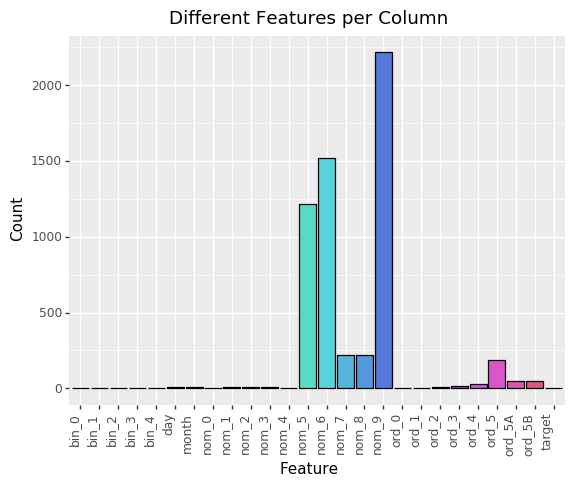

<ggplot: (8787951827653)>

In [63]:
df_count_per_col = pd.DataFrame(df_train.nunique())
df_count_per_col.columns = ['Values']
df_count_per_col.index.name = 'Feature'
df_count_per_col.reset_index(inplace=True)

ggplot(df_count_per_col[df_count_per_col['Feature'] != 'id'], 
       aes(x = 'Feature', y = 'Values', fill = 'Feature')) + geom_bar(stat = 'identity', color = 'black') +\
    theme(axis_text_x = element_text(angle = 90, hjust = 1), legend_position = 'none') +\
    ggtitle('Different Features per Column') + ylab('Count')

Another important information to explore is the missing data rate: how many "NAN's" do we have per column?

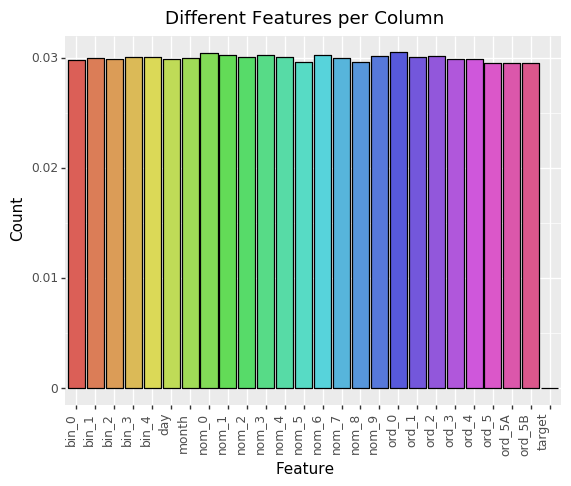

<ggplot: (8787951826780)>

In [64]:
df_missing_col = pd.DataFrame(dict(PercMissing = df_train.isnull().sum() / 
                                   len(df_train.index))).reset_index()
df_missing_col.loc[df_missing_col['PercMissing'] > 0, :]

ggplot(df_missing_col[df_missing_col['Feature'] != 'id'], 
       aes(x = 'Feature', y = 'PercMissing', fill = 'Feature')) + geom_bar(stat = 'identity', color = 'black') +\
    theme(axis_text_x = element_text(angle = 90, hjust = 1), legend_position = 'none') +\
    ggtitle('Different Features per Column') + ylab('Count')

It would be nice to follow a similar approach with the rows and check if we have a row with many missing values. If so, we can just drop them out without the risk of losing many informations.

It's not a good idea to try to do that with 600.000 different index values. So, let's just check the maximum missing data rate along all the rows:

In [65]:
df_missing_row = pd.DataFrame(dict(PercMissing = df_train.isnull().sum(axis=1) / 
                                   len(df_train.index))).reset_index()

df_missing_row.columns = ['Index', 'PercMissing']
print(str(100 * max(df_missing_row['PercMissing'])) + ' %')

0.0013333333333333333 %


It's really small, so, we will not drop out any row and we are ready to start transforming our dataset. Also, since we have no high missing NA values per columns or rows, we don't need to spend a lot of time in the missing data imputation step.

Let's start out data transformation step by separing the variables in different classifications:

In [83]:
binary_features = ['bin_' + str(i) for i in range(0, 5)]
nominal_features_low_count = ['nom_' + str(i) for i in range(0, 5)]
nominal_features_high_count = ['nom_' + str(i) for i in range(5, 10)]
ordinal_features_low_count = ['ord_' + str(i) for i in range(0, 5)]
ordinal_features_high_count = ['ord_5'] + ['ord_5A', 'ord_5B']
date_features = ['day', 'month']

And we will use the "SimpleImputer" class to fill the missing data. But I will just "correct" a problem in its source code: [Stack Overflow Question](https://datascience.stackexchange.com/questions/66034/sklearn-simpleimputer-too-slow-for-categorical-data-represented-as-string-values). Imputing the median of the values is slow and using the "constant" imputation method for each column with the most frequent value as constant can speed up the code considerably!

Thanks to the techniques of object orientation, we can inherit the methods of the original function and create a new "most_frequent" imputation method where we use, in each column, the Stack Overflow's purposed solution:

In [84]:
class SimpleImputerCorrected(BaseEstimator, TransformerMixin):
    
    def __init__(self, strategy='most_frequent', verbose=False):
        
        self.strategy = strategy
        self.preprocessor = None
        self.verbose = verbose

    def fit(self, X, y=None):
        
        if self.strategy == 'most_frequent':
            
            col_list = list(X.columns)
            col_transformers = list()
            col_mode = X.mode(axis=0).iloc[0]
        
            for curr_col in col_list:
                curr_transformer_name = 'T_' + curr_col
                curr_imputer = SimpleImputer(strategy='constant', 
                                             fill_value=col_mode[curr_col])
                col_transformers.append((curr_transformer_name, curr_imputer, 
                                         [curr_col]))
            
            self.preprocessor = ColumnTransformer(transformers=col_transformers, verbose=self.verbose)
            
        else:
            self.preprocessor = SimpleImputer(strategy=self.strategy)
            
        self.preprocessor.fit(X)
        return self

    def transform(self, X):
        return self.preprocessor.transform(X)

All the steps described until now will be inserted in a Scikit's Pipeline! It's a functionality that allow us to define a sequence of transformation and modeling steps as a class that can be used in different datasets when, for example, our model is running in production. Let's see some Pipeline examples in the next figure:

![Pipelines](https://www.researchgate.net/publication/334565019/figure/fig1/AS:782364141690881@1563541555043/The-Auto-Sklearn-pipeline-12-contains-three-main-building-blocks-a-Data.png)

Our first pipelines will be not so complicated and the code is self-explainable:

What can we do with the ordinal and categorical features with many different values? I will apply the same threatment: the **Target Encoding**. It consists in transforming each category into the averages of the targets obtained for this category. 

I am considering that our ordinal feature with a high number of different values (ord_5) is categorical: we have $2$ random letters together, some of them in uppercase, some of them in lowercase characters and I am not really sure about how could I possibly transform it to an ordinal number that makes sense (should we sum the ASCII values? Should we sum the ASCII values after transforming the characters to their lowercase versions?)

In [99]:
pass_features = binary_features + ordinal_features_low_count
one_hot_features = nominal_features_low_count
avg_features = nominal_features_high_count + ordinal_features_high_count

pass_pipeline = Pipeline(steps = [
    ('imputation', SimpleImputerCorrected(strategy='most_frequent')),
    ('scalling', StandardScaler())
], verbose = True)

one_hot_pipeline  = Pipeline(steps = [
    ('imputation', SimpleImputerCorrected(strategy='most_frequent')),
    ('encoding', OneHotEncoder(sparse = False)),
    ('scalling', StandardScaler())
], verbose = True)

avg_pipeline = Pipeline(steps = [
    ('imputation', SimpleImputerCorrected(strategy='most_frequent')),
    ('encoding', TargetEncoder()),
    ('scalling', StandardScaler())
], verbose = True)

encoder = ColumnTransformer(
    transformers=[
        ('pass_pipeline', pass_pipeline, pass_features),
        ('one_hot_pipeline', one_hot_pipeline, one_hot_features),
        ('avg_pipeline', avg_pipeline, avg_features)
], verbose = True, sparse_threshold=0)

In [119]:
train_loc = (df_train.columns != 'target') & (df_train.columns != 'id')
test_loc = (df_test.columns != 'target') & (df_test.columns != 'id')

df_train.loc[:, train_loc].head()

Feature,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,ord_5A,ord_5B
0,0.0,0.0,0.0,0.0,0.0,Red,Trapezoid,Hamster,Russia,Bassoon,...,3.0,2.0,4.0,99.0,85.0,Pw,6.0,3.0,80.0,119.0
1,1.0,1.0,0.0,0.0,1.0,Red,Star,Axolotl,NaN,Theremin,...,3.0,5.0,3.0,101.0,88.0,pE,7.0,7.0,112.0,69.0
2,0.0,1.0,0.0,0.0,0.0,Red,NaN,Hamster,Canada,Bassoon,...,3.0,NaN,1.0,110.0,80.0,eN,5.0,9.0,101.0,78.0
3,NaN,0.0,0.0,0.0,0.0,Red,Circle,Hamster,Finland,Theremin,...,1.0,1.0,6.0,97.0,67.0,NaN,3.0,3.0,NaN,NaN
4,0.0,NaN,0.0,1.0,0.0,Red,Triangle,Hamster,Costa Rica,NaN,...,3.0,5.0,2.0,104.0,67.0,OZ,5.0,12.0,79.0,90.0


In [101]:
array_train = encoder.fit_transform(df_train.loc[:, train_loc], df_train['target'])

[Pipeline] ........ (step 1 of 2) Processing imputation, total=   0.3s
[Pipeline] .......... (step 2 of 2) Processing scalling, total=   0.2s
[ColumnTransformer] . (1 of 3) Processing pass_pipeline, total=   0.5s
[Pipeline] ........ (step 1 of 3) Processing imputation, total=   0.4s
[Pipeline] .......... (step 2 of 3) Processing encoding, total=   0.7s
[Pipeline] .......... (step 3 of 3) Processing scalling, total=   0.4s
[ColumnTransformer]  (2 of 3) Processing one_hot_pipeline, total=   1.5s
[Pipeline] ........ (step 1 of 3) Processing imputation, total=   0.8s
[Pipeline] .......... (step 2 of 3) Processing encoding, total=   2.1s
[Pipeline] .......... (step 3 of 3) Processing scalling, total=   0.1s
[ColumnTransformer] .. (3 of 3) Processing avg_pipeline, total=   3.0s


Now, we will use in the next section the Principal Component Analysis technique to remove redundant dimentions of our variables.

# 2. Dimentionality Reduction With Principal Component Analysis
## 2.1. Linear Transformations

The principal component analysis is, itself, a Scikit-Learn model. It's basically a simple linear transformation that is applied to out dataset. When I say that I am applying a linear transformation over a vector, I'm saying that I'm multiplying this vector by a matrix:

$$V_{Transformed} = A.V_{Before}$$

Where $V_{Before}$ is a single vector, with a number of dimentions equal to the number of columns of our original dataframe and we have as many vectors as rows in our dataset.

Initially, we apply a $N \times N$ matrix over our vectors, where $N$ is the number of columns. It means that we are using all the output dimentions of the vector.

![LinearTransformation](http://duriansoftware.com/joe/media/gl3-linear-transformation-matrices-01.png)

If we apply the same linear transformation over different vectors, as we can see in the figure above, the angle between the two vectors will change and some components will be "stretched" ou "shrinked" as we can see in the figure above.

In the Principal Component Analysis we don't apply any linear transformation over our dataset. We will change the angle of each pair of vectors to $90$ degrees and obtain independent components (i.e vectors with no mutual projections over each other):

![PCA](https://i2.wp.com/www.sportscidata.com/wp-content/uploads/2019/08/Principal_Component_Analysis_print.png?fit=1024%2C683&ssl=1)

** This transformation is applied over the centered vectors, as we will explain in the next section **

## 2.2. Variances and Features Importance

Suppose we have two non orthogonal vectors in a bidimentional space and we want to calculate the sum of the variance along the $2$ dimensions. Then we have:

$$Var(X_{12}) = Var(X_1) + Var(X_2) + 2.Cov(X_1, X_2)$$

After applying a PCA over this pair, we obtain $2$ orthogonal vectors and the total variance can be calculated without the covariance term:

$$Var(X^*_{12}) = Var(X^*_1) + Var(X^*_2)$$

Where:
$$ X^*_1 = \Lambda . (X_1 - \mu_{1,2}) $$
$$ X^*_2 = \Lambda . (X_2 - \mu_{1,2}) $$
$$ X^*_1 \perp X^*_2 \rightarrow X^*_1 \bullet X^*_2 = 0 $$
$$ \mu_{1,2} = \frac{X_1 + X_2}{2} $$

And $\Lambda$ is our linear transformation PCA matrix. When we lose the covariance term and subtract the mean of each vector, something magic happens:

$$ Var({X^*_k}) = \mathbb{E} [{X^*_k}^2 - \mathbb{E} [{X^*_k}]^2] $$

Since we centered our data:

$ \mathbb{E} [{X^*_k}]^2 = 0 $

Then:

$\frac{Var({X^*_k})}{Var_{Total}} = \frac{\mathbb{E} [{X^*_k}^2]}{Var_{Total}} = \frac{|| {X^*_k}^2 ||_2}{Var_{Total}}$

And the participation of each feature over the total variance is proportional to the squared norm of the principal component! It also applies to more dimentions (we would do exactly the same steps).

Components with neglectable importances may be ignored without any risk to spoil the final model and with the benefit of reducting the computational weight of the model.

Applying our Scikit's PCA:

In [102]:
data_pca = PCA().fit_transform(array_train) 

This is the transformed dataset:

In [103]:
data_pca

array([[-1.06764355e+00, -1.09854163e+00,  1.75562064e+00, ...,
         2.87464610e-14,  3.07336573e-14, -2.76832757e-15],
       [ 1.52305062e+00, -1.18193481e+00, -1.13947570e+00, ...,
        -5.50646270e-14, -1.56650347e-13, -8.24825779e-14],
       [ 6.33718983e-01, -1.06704930e+00,  1.75867221e+00, ...,
        -1.06730704e-13, -1.29337384e-13,  1.59163338e-14],
       ...,
       [-1.31489789e+00, -1.22036723e+00, -1.14383828e+00, ...,
         1.16606724e-16, -5.03769525e-16,  4.42604297e-16],
       [-1.77344242e+00, -1.15128771e+00,  7.16265424e-01, ...,
        -1.82401269e-16, -1.02760699e-16,  1.83812193e-16],
       [ 2.34212717e+00,  1.71387819e+00, -1.29312077e+00, ...,
         7.09204530e-17,  3.74455576e-16,  1.34620165e-16]])

In [104]:
data_pca.shape

(600000, 43)

I usually like to plot the feature importances from the most important variable to the less important one in a Paretto's diagram:

In [105]:
var_pca = data_pca.var(axis = 0)
imp_pca = var_pca / sum(var_pca)
cum_imp_pca = np.cumsum(imp_pca)

list_vars = var_pca.tolist() + imp_pca.tolist() + cum_imp_pca.tolist()
named_vars = ['Variance'] * len(var_pca) +\
             ['Importance'] * len(imp_pca) +\
             ['Cumulative_Importance'] * len(cum_imp_pca)
        
df_pca = pd.DataFrame(dict(
    IndexStr=[str(i) for i in 3 * list(range(0, len(named_vars) // 3))],
    Index=3 * list(range(0, len(named_vars) // 3)),
    Variable=named_vars,
    Value=list_vars
))

df_pca.head()

,IndexStr,Index,Variable,Value
0,0,0,Variance,1.969361
1,1,1,Variance,1.842876
2,2,2,Variance,1.778628
3,3,3,Variance,1.397349
4,4,4,Variance,1.396079


After processing the Paretto's plot data in a dataframe, let's check the diagram:

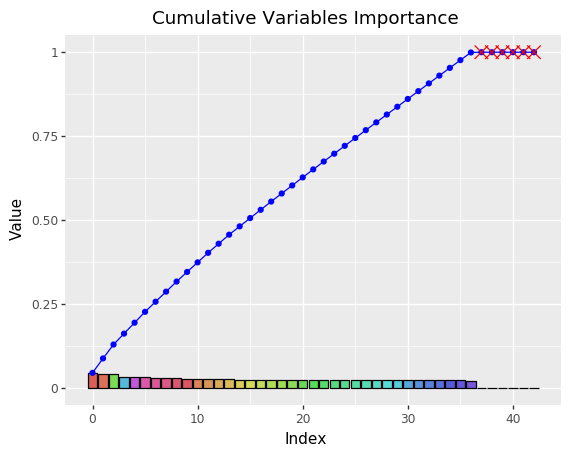

<ggplot: (-9223363248845259825)>

In [106]:
ggplot(aes(x = 'Index', y = 'Value')) +\
    geom_bar(aes(fill = 'IndexStr'), color = 'black', stat = 'identity', data = df_pca[df_pca['Variable'] == 'Importance']) +\
    theme(legend_position = 'none') + ggtitle('Cumulative Variables Importance') +\
    geom_line(data = df_pca[df_pca['Variable'] == 'Cumulative_Importance'], color = 'blue') +\
    geom_point(data = df_pca[df_pca['Variable'] == 'Cumulative_Importance'], color = 'blue') +\
    geom_point(data = df_pca[(df_pca['Variable'] == 'Cumulative_Importance') &\
                             (df_pca['Value'] > 0.9999999999)], color = 'red', shape = 'x', size = 5)

The red "X" is marked over the points where the cumulative importance is really, really near of $100 \%$.

In [107]:
imp_pca[35:-1]

array([2.29900347e-02, 2.28523293e-02, 7.53808296e-04, 5.78809129e-33,
       1.33854758e-32, 8.35449382e-33, 7.82439145e-33])

It's true! And we are ready to create our final pipeline, including the dimentionality reduction. It will be created with the aid of a parametric function:

In [108]:
def get_preprocessor(pass_features=binary_features + ordinal_features_low_count, 
                     one_hot_features=nominal_features_low_count, 
                     avg_features=nominal_features_high_count + ordinal_features_high_count, 
                     te_smoothing=1,
                     pca_threshold=0.9999):

    pass_pipeline = Pipeline(steps = [
        ('imputation', SimpleImputerCorrected(strategy='most_frequent')),
        ('scalling', StandardScaler())])

    one_hot_pipeline  = Pipeline(steps = [
        ('imputation', SimpleImputerCorrected(strategy='most_frequent')),
        ('encoding', OneHotEncoder(sparse = False))])

    avg_pipeline = Pipeline(steps = [
        ('imputation', SimpleImputerCorrected(strategy='most_frequent')),
        ('encoding', TargetEncoder(smoothing = te_smoothing)),
        ('scalling', StandardScaler())])

    encoder = ColumnTransformer(
    transformers=[
        ('pass_pipeline', pass_pipeline, pass_features),
        ('one_hot_pipeline', one_hot_pipeline, one_hot_features),
        ('avg_pipeline', avg_pipeline, avg_features)
    ], sparse_threshold=0)
    
    if (pca_threshold > 0):
        preprocessor = Pipeline(steps = [('encoder', encoder), ('pca', PCA(n_components=pca_threshold))])
    else:
        preprocessor = Pipeline(steps = [('encoder', encoder)])
    return preprocessor

# 3. Individual Model Selection + Validation

In [109]:
pass_list = [pass_features, pass_features, pass_features]

one_hot_list = [nominal_features_low_count + ordinal_features_low_count,
                nominal_features_low_count, []]

avg_list = [avg_features,
            avg_features + ordinal_features_low_count,
            avg_features + ordinal_features_low_count + nominal_features_low_count]

transformers_name = ['minimum_te', 'medium_te', 'maximum_te']
transformers_list = zip(transformers_name, pass_list, one_hot_list, avg_list)

hyper_pipe_dict = {
    'lor_model__solver': ['saga'],
    'lor_model__penalty': ['elasticnet'],
    'lor_model__C': [0.1, 1, 10],
    'lor_model__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
    'preprocessor__transformers': transformers_list,
    'preprocessor__target_smoothing': [0.1, 1, 10]
}

In [110]:
y_train = df_train['target']
k_fold_n_splits, k_fold_use = 20, 3

iter_list = []
C_list = []
l1_list = []
t_list = []
smoothing_list = []
solver_list = []
penalty_list = []
train_score_list = []
test_score_list = []

for t_name, t_pass, t_one_hot, t_avg in hyper_pipe_dict['preprocessor__transformers']:
    for C in hyper_pipe_dict['lor_model__C']:
        for l1_ratio in hyper_pipe_dict['lor_model__l1_ratio']:
            for target_smoothing in hyper_pipe_dict['preprocessor__target_smoothing']:
                for solver in hyper_pipe_dict['lor_model__solver']:
                    for penalty in hyper_pipe_dict['lor_model__penalty']:
                        iter_list.append([C, l1_ratio, t_name, t_pass, t_one_hot, t_avg, 
                                          target_smoothing, solver, penalty])

In [111]:
cross_validate = True

In [112]:
if cross_validate:
    
    def train_test_score(iter_items):
        
        C, l1_ratio, t_name, t_pass, t_one_hot, t_avg, target_smoothing, solver, penalty = iter_items
        preprocessing_pipeline = get_preprocessor(t_pass, t_one_hot, t_avg, target_smoothing)
        x_train = preprocessing_pipeline.fit_transform(df_train.loc[:, train_loc], y_train)
                        
        k_fold_obj = StratifiedKFold(n_splits=k_fold_n_splits, shuffle=True)
        k_fold_count = 0
        
        
        roc_auc_train = 0
        roc_auc_test = 0
        
        for train_index, test_index in k_fold_obj.split(x_train, y_train):
            if k_fold_count >= k_fold_use:
                break
            else:
                k_fold_count += 1
                            
                x_cv_train, y_cv_train = x_train[train_index], y_train[train_index]
                x_cv_test, y_cv_test = x_train[test_index], y_train[test_index]
                            
                curr_lor = LogisticRegression(C=C, l1_ratio=l1_ratio, solver=solver, penalty=penalty, n_jobs=-1)
                curr_lor.fit(x_cv_train, y_cv_train)
                            
                y_cv_train_pred = curr_lor.predict_proba(x_cv_train)[:, 1]
                y_cv_test_pred = curr_lor.predict_proba(x_cv_test)[:, 1]
                            
                roc_auc_train += roc_auc_score(y_cv_train, y_cv_train_pred)
                roc_auc_test += roc_auc_score(y_cv_test, y_cv_test_pred)
                
        return [(roc_auc_train / k_fold_use), (roc_auc_test / k_fold_use)]
            
    cv_results = Parallel(n_jobs=6)(delayed(train_test_score)(iter_items) for iter_items in tqdm(iter_list))



  0%|          | 0/135 [00:00<?, ?it/s]

  1%|          | 1/135 [00:00<00:21,  6.37it/s]

  1%|▏         | 2/135 [00:00<00:44,  2.99it/s]

  9%|▉         | 12/135 [02:22<09:10,  4.48s/it]

 10%|▉         | 13/135 [02:26<08:53,  4.37s/it]

 10%|█         | 14/135 [02:29<07:48,  3.87s/it]

 11%|█         | 15/135 [02:34<08:52,  4.44s/it]

 12%|█▏        | 16/135 [02:44<12:01,  6.06s/it]

 13%|█▎        | 17/135 [03:09<22:44, 11.56s/it]

 13%|█▎        | 18/135 [04:47<1:13:09, 37.52s/it]

 14%|█▍        | 19/135 [04:55<55:26, 28.68s/it]  

 15%|█▍        | 20/135 [04:55<38:47, 20.24s/it]

 16%|█▋        | 22/135 [05:05<29:21, 15.59s/it]

 17%|█▋        | 23/135 [06:06<54:36, 29.26s/it]

 18%|█▊        | 24/135 [07:03<1:09:32, 37.59s/it]

 19%|█▊        | 25/135 [07:08<50:43, 27.67s/it]  

 19%|█▉        | 26/135 [07:11<36:54, 20.32s/it]

 20%|██        | 27/135 [07:31<36:38, 20.36s/it]

 21%|██        | 28/135 [07:51<35:46, 20.06s/it]

 21%|██▏       | 29/135 [08:09<34:24, 19.48s/it]

 

In [113]:
train_results = [X[0] for X in cv_results]
test_results = [X[1] for X in cv_results]

C_list = [X[0] for X in iter_list]
l1_list = [X[1] for X in iter_list]
t_list = [X[2] for X in iter_list]
smoothing_list = [X[6] for X in iter_list]

df_cv = pd.DataFrame(
    dict(
        C=C_list,
        L1=l1_list,
        T_Name=t_list,
        Smoothing=smoothing_list,
        Train_AUC=train_results,
        Test_AUC=test_results
    )
)

df_cv.to_csv('./df_cv.csv', index=False)

In [114]:
df_cv.sort_values(by='Test_AUC', ascending=False).iloc[0:20, :]

,C,L1,T_Name,Smoothing,Train_AUC,Test_AUC
4,0.1,0.25,minimum_te,1.0,0.782095,0.786633
107,1.0,0.00,maximum_te,10.0,0.781649,0.786412
38,10.0,0.50,minimum_te,10.0,0.782135,0.785827
106,1.0,0.00,maximum_te,1.0,0.781738,0.784691
98,0.1,0.50,maximum_te,10.0,0.781741,0.784683
13,0.1,1.00,minimum_te,1.0,0.782209,0.784529
66,1.0,0.50,medium_te,0.1,0.781773,0.784515
125,10.0,0.25,maximum_te,10.0,0.781751,0.784450
79,10.0,0.25,medium_te,1.0,0.781781,0.784413
99,0.1,0.75,maximum_te,0.1,0.781757,0.784342


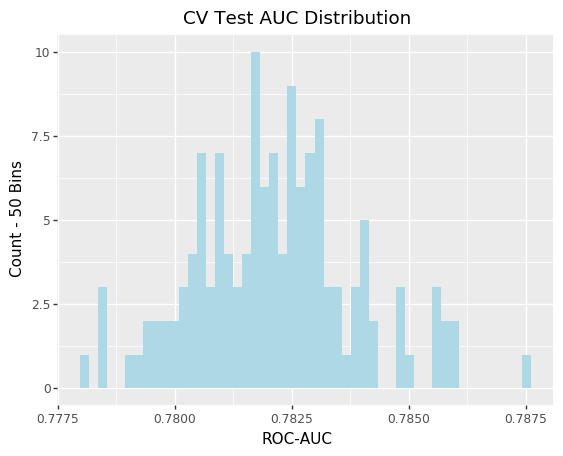

<ggplot: (-9223363291034147426)>

In [38]:
ggplot(df_cv, aes(x='Test_AUC')) + geom_histogram(bins = 50, fill = 'lightblue') +\
    ggtitle('CV Test AUC Distribution') + xlab('ROC-AUC') + ylab('Count - 50 Bins')

In [118]:
# C 	    L1 	    T_Name 	    Smoothing 	Train_AUC 	Test_AUC
# 0.1 	    0.25 	minimum_te 	1.0 	    0.782095 	0.786633
# 1.0 	    0.00 	maximum_te 	10.0 	    0.781649 	0.786412

opt_pipe_A = get_preprocessor(pass_features, ordinal_features_low_count + nominal_features_low_count, avg_features, 1.)
opt_pipe_B = get_preprocessor(pass_features, [], avg_features + ordinal_features_low_count + nominal_features_low_count, 10.)

opt_pipe_A.fit(df_train.loc[:, train_loc], y_train)
opt_pipe_B.fit(df_train.loc[:, train_loc], y_train)

opt_model_A = LogisticRegression(C=0.1, l1_ratio=0.25, solver='saga', penalty='elasticnet')
opt_model_B = LogisticRegression(C=1.0, l1_ratio=0.00, solver='saga', penalty='elasticnet')

x_pipe_A = opt_pipe_A.transform(df_train.loc[:, train_loc])
x_pipe_B = opt_pipe_B.transform(df_train.loc[:, train_loc])

opt_model_A.fit(x_pipe_A, y_train)
opt_model_B.fit(x_pipe_B, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.0, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [120]:
target_A = opt_model_A.predict_proba(opt_pipe_A.transform(df_test.loc[:, test_loc]))[:, 1]
target_B = opt_model_B.predict_proba(opt_pipe_B.transform(df_test.loc[:, test_loc]))[:, 1]

In [121]:
pd.DataFrame({
    'id': df_test['id'],
    'target': target_A
}).to_csv('./df_out_logistic_model_A.csv', index=False)

pd.DataFrame({
    'id': df_test['id'],
    'target': target_B
}).to_csv('./df_out_logistic_model_B.csv', index=False)

In [ ]:
target_A[(target_A > 0.5) != (target_B > 0.5)]

In [ ]:
target_B[(target_A > 0.5) != (target_B > 0.5)]